## Importing Common Libs

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch 
import json
import sys
import torch
import torch.nn.functional as F
import os
import numpy as np

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

In [12]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## UMAP 

In [ ]:
reductions_dims = 2
plot_figure = True 

import pickle 
import umap

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label, _) in enumerate(train_loader):
    # remove channel dim (used for conv)
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 196)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]


# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


# UMAP reduction
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=reductions_dims, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data_sampled)

# Plotting (if conditions are met)
if reductions_dims == 2 and plot_figure == True:
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('UMAP projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="umap", model=reducer, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output_relu", classifier_dims=2)
classifier_model = classifier_model.to(device)


In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=1, desired_total_batches=5, patience=8)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## PCA Plot Visual Inspection (Not needed for later steps)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

reductions_dims = 2
plot_figure = True

list_of_data = []
list_of_ground_truth = []

for i, (data, ground_truth_label, _) in enumerate(test_loader):
    # Remove channel dimension (used for convolutional layers)
    data = data[:, 0, :, :]
    # Permute dimensions
    data = data.permute(0, 2, 1)
    # Convert labels to indices
    ground_truth_label = ground_truth_label.argmax(-1)
    # Convert to numpy arrays
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    # Reshape labels
    ground_truth_label = ground_truth_label.reshape(-1, 1)
    data = data.reshape(-1, 1 * 196)
    # Append to lists
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    # Break the loop after processing 101 batches
    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]

# Load color map data
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Map labels to colors
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

# Prepare colors for plotting points
colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)

# Initialize and apply PCA
pca = PCA(n_components=reductions_dims, random_state=42)
embedding_outputs = pca.fit_transform(list_of_data_sampled)

# Plot if conditions are met
if reductions_dims == 2 and plot_figure == True:
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('PCA projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="pca", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=2)
classifier_model = classifier_model.to(device)

In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1, patience=4)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## Raw Spectogram

In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="raw", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=196)
classifier_model = classifier_model.to(device)

In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1e4, patience=4)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## SAP Factors

## AVES

In [7]:
import torchaudio
from torch import nn
import torch
import json
from torchaudio.models import wav2vec2_model

class AvesTorchaudioWrapper(nn.Module):
    def __init__(self, config_path, model_path):
        super().__init__()
        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        self.model.feature_extractor.requires_grad_(False)

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)
        return obj

    def forward(self, sig):
        out = self.model.extract_features(sig)[0][-6]
        return out

model_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.pt"
config_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.model_config.json"
test_song = "/home/george-vengrovski/Documents/data/llb3_data_wav/llb3_songs/llb3_0001_2018_04_23_14_18_03.wav"

torchaudio_model = AvesTorchaudioWrapper(config_path, model_path)
torchaudio_model.eval()

# Load test song audio waveform and downsample to 16000 Hz
waveform, sample_rate = torchaudio.load(test_song)
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

# Forward pass through the model
output = torchaudio_model.forward(waveform)
print(output.shape)

torch.Size([1, 70, 768])


In [8]:
import pandas as pd

# Load the specified CSV file into a DataFrame
df = pd.read_csv('/home/george-vengrovski/Documents/data/llb3_data_wav/llb3_annot.csv')

sample_freq = 16000 

# Function to include the first onset and the last offset value for contiguous groups
def aggregate_onset_offset(df, filename, label, onset, offset):
    # Create a new column to identify contiguous groups
    df['group'] = (df[filename] != df[filename].shift(1)) | (df[label] != df[label].shift(1))
    df['group'] = df['group'].cumsum()

    # Aggregate the first onset and the last offset for each group
    aggregated_df = df.groupby(['group', filename, label], as_index=False).agg({onset: 'first', offset: 'last'})

    # Drop the group column from the aggregated dataframe
    aggregated_df = aggregated_df.drop(columns=['group'])

    return aggregated_df

# Aggregate and include the first onset and the last offset
aggregated_df_onset_offset = aggregate_onset_offset(df, 'audio_file', 'label', 'onset_s', 'offset_s')

# Add new columns for onset and offset multiplied by the sample frequency
aggregated_df_onset_offset['onset_sample'] = aggregated_df_onset_offset['onset_s'] * sample_freq
aggregated_df_onset_offset['offset_sample'] = aggregated_df_onset_offset['offset_s'] * sample_freq


In [9]:

aggregated_df_onset_offset['onset_sample'] = (aggregated_df_onset_offset['onset_sample']).round()
aggregated_df_onset_offset['offset_sample'] = (aggregated_df_onset_offset['offset_sample']).round()

In [10]:
# Save the updated DataFrame to a CSV file
output_file_path_onset_offset = 'test.csv'
aggregated_df_onset_offset.to_csv(output_file_path_onset_offset, index=False)

## Dataloader for AVES

In [13]:
import torch.nn.functional as F
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import soundfile as sf
import torchaudio

label_file_path = "test.csv"
data_path = "/home/george-vengrovski/Documents/data/llb3_data_wav/llb3_songs"

class AVES_DataClass(Dataset):
    def __init__(self, label_file_path, data_path):
        self.label_file_path = label_file_path
        self.data_path = data_path
        self.file_path = []
        self.labels = [] 

        # Load label file into a DataFrame
        label_df = pd.read_csv(self.label_file_path)

        # Iterate over files in the data path
        for file in os.listdir(self.data_path):
            # Get label where the first column matches file_name
            label = label_df[label_df[label_df.columns[0]] == file]
            
            # Append label to the labels list
            # Assuming you need the entire row from label_df as the label
            if not label.empty:
                relevant_columns = ['label', 'onset_sample', 'offset_sample']
                label = label[relevant_columns].astype(int).to_csv(index=False, header=False)
                data = [line.split(',') for line in label.strip().split('\n')]
                label = np.array(data, dtype=int)
                self.labels.append(label)
                file_path = os.path.join(self.data_path, file)
                self.file_path.append(file_path)
            else:
                continue

    def __getitem__(self, index):
        file_path = self.file_path[index]
        label = self.labels[index]

        try:
            waveform, sample_rate = torchaudio.load(file_path)
       
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            waveform = waveform.squeeze(0)

            # create labels tensor of the same length as song 
            labels = torch.zeros_like(waveform.squeeze(0))
    
            # fill in values of labels array 
            for row in label:
                label_value = row[0]
                onset = row[1]
                offset = row[2]
                labels[onset:offset] = label_value

            return waveform, labels
        except Exception as e:
            return str(e)

    def __len__(self):
        return len(self.file_path)

# class CollateFunction:
#     def __init__(self, max_length=64e3):
#         # default max length is 64k samples, or 4 seconds at 16khz sample rate 
#         self.max_length = max_length

#     def __call__(self, batch):
#         # Unzip the batch (a list of (spectogram, psuedo_labels, ground_truth_labels) tuples)
#         waveform, labels = zip(*batch)

#         # Create lists to hold the processed tensors
#         spectograms_processed = []
#         psuedo_labels_processed = []
#         ground_truth_labels_processed = []

#         # Each sample in batch
#         for spectogram, psuedo_label, ground_truth_label in zip(spectograms, psuedo_labels, ground_truth_labels):

#             # Truncate if larger than context window
#             if spectogram.shape[0] > self.segment_length:
#                 # get random view of size segment
#                 # find range of valid starting pts (essentially these are the possible starting pts for the length to equal segment window)
#                 starting_points_range = spectogram.shape[0] - self.segment_length        
#                 start = torch.randint(0, starting_points_range, (1,)).item()  
#                 end = start + self.segment_length     

#                 spectogram = spectogram[start:end]
#                 psuedo_label = psuedo_label[start:end]
#                 ground_truth_label = ground_truth_label[start:end]

#             # Pad with 0s if shorter
#             if spectogram.shape[0] < self.segment_length:
#                 pad_amount = self.segment_length - spectogram.shape[0]
#                 spectogram = F.pad(spectogram, (0, 0, 0, pad_amount), 'constant', 0)
#                 psuedo_label = F.pad(psuedo_label, (0, 0, 0, pad_amount), 'constant', 0)  # Adjusted padding for labels
#                 ground_truth_label = F.pad(ground_truth_label, (0, 0, 0, pad_amount), 'constant', 0)  # Adjusted padding for labels

#             # Append the processed tensors to the lists
#             spectograms_processed.append(spectogram)
#             psuedo_labels_processed.append(psuedo_label)
#             ground_truth_labels_processed.append(ground_truth_label)

#         # Stack tensors along a new dimension to match the BERT input size.
#         # You might need to adjust dimensions based on your exact use case.
#         spectograms = torch.stack(spectograms_processed, dim=0)
#         psuedo_labels = torch.stack(psuedo_labels_processed, dim=0)
#         ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

#         # Final reshape for model
#         spectograms = spectograms.unsqueeze(1).permute(0,1,3,2)

#         return spectograms, psuedo_labels, ground_truth_labels

umap_dataclass = AVES_DataClass(label_file_path=label_file_path, data_path=data_path)
umap_dataloader = DataLoader(umap_dataclass, batch_size=1, shuffle=True)
file, label = (next(iter(umap_dataloader)))

print(label.shape)
print(file.shape)

torch.Size([1, 39859])
torch.Size([1, 39859])


In [25]:
import torch
from scipy import stats

def adaptive_mode_pool1d(input_tensor, output_size):
    # Correctly obtaining the size of the feature dimension
    input_size = input_tensor.size()[1]  

    stride = input_size // output_size
    kernel_size = input_size - (output_size - 1) * stride

    # Initialize output tensor
    output = torch.zeros(input_tensor.size(0), output_size, dtype=input_tensor.dtype, device=input_tensor.device)

    # Iterate over each window and calculate mode
    for i in range(output_size):
        start_i = i * stride
        end_i = start_i + kernel_size

        window = input_tensor[:, start_i:end_i]
        mode_values, _ = stats.mode(window.cpu().numpy(), axis=1)
        output[:, i] = torch.from_numpy(mode_values).to(input_tensor.device)

    return output


# model_output_
def adjust_labels(model_output_length, labels):
    return adaptive_mode_pool1d(labels, model_output_length)

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


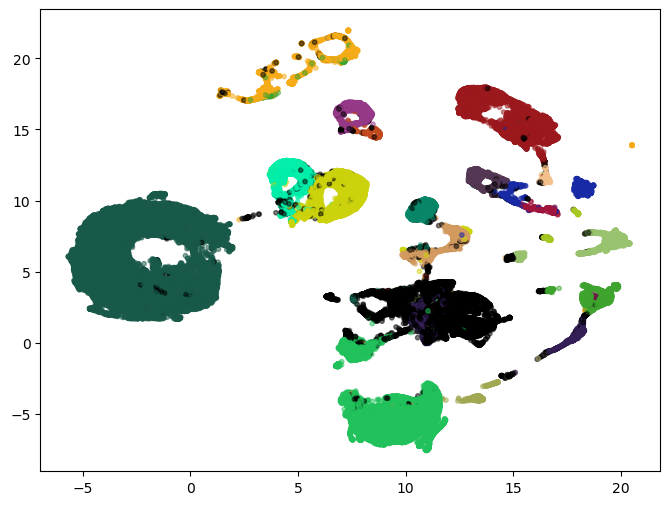

In [30]:
import umap
import pickle
import umap as umap


color_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/category_colors_llb3.pkl"

samples = 100
counter = 0 

labels_list = []
activations_list = []

while samples > counter:
    counter+=1

    file, label = (next(iter(umap_dataloader)))
    output = torchaudio_model.forward(file)
    # model output shape is batch, time bins, dims 
    adjusted_labels = adjust_labels(model_output_length=output.shape[1], labels=label)

    output = output.reshape(-1, output.shape[-1]).cpu().detach().numpy()
    adjusted_labels = adjusted_labels.reshape(-1, 1).cpu().detach().numpy()

    labels_list.append(adjusted_labels)
    activations_list.append(output)

labels = np.concatenate(labels_list)
activations = np.concatenate(activations_list)
activations = np.nan_to_num(activations)

with open(color_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in labels:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)

reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=2, metric='euclidean')
embedding_outputs = reducer.fit_transform(activations)

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=10, c=colors_for_points, alpha=.5)
plt.show()
# # Apply UMAP
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(output[0].detach().cpu().numpy())

# # Plotting
# plt.scatter(embedding[:, 0], embedding[:, 1])
# plt.title("UMAP Projection of Model Output")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.show()